In [1]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HF_HUB_OFFLINE"] = "1"
# os.environ["MAX_PIXELS"]=


In [2]:
import torch
import torch.nn.functional as F
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# model_7b = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-7B-Instruct",
#     torch_dtype="auto",
#     #  attn_implementation="sdpa",
#     #  device_map="auto",
# ).to("cuda:2")
model_2b = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype="auto",
    attn_implementation="eager",
    # device_map="auto",
).to("cuda:3")
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct", use_fast=True)
# processor_2b = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
from VLMEvalKit.vlmeval.vlm.qwen2_vl.qwen_mod_forward import (
    patch_forward,
    get_mean_attn_score,
    get_visual_token_mean_attn_score,
    get_visual_token_weight,
    calculate_dynamic_threshold,
)


[2025-03-24 19:56:57] ERROR - misc.py: load_env - 212: Did not detect the .env file at /home/seas0/SyncedWorkspace/MLLM-Attention/VLMEvalKit/.env, failed to load. 
[2025-03-24 19:56:57] ERROR - misc.py: load_env - 212: Did not detect the .env file at /home/seas0/SyncedWorkspace/MLLM-Attention/VLMEvalKit/.env, failed to load. 


In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "examples/img4.png",
            },
            {"type": "text", "text": "How many yellow objects are there in the image?"},
        ],
    }
]

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
# print(image_inputs)


In [6]:
import numpy as np
from PIL import Image
from IPython.display import display

def generate_images(image_list, mode="noise", color=(255, 255, 255)):
    """
    根据 `mode` 生成与 `image_list` 中图像等大的随机噪声或纯色图像。

    参数：
    - image_list: list[PIL.Image]，输入的图像列表。
    - mode: str，"noise" 生成随机噪声图像，"blank" 生成纯色图像。
    - color: tuple，生成纯色图像时的颜色，默认为白色 (255, 255, 255)。

    返回：
    - list[PIL.Image]，生成的图像列表。
    """
    generated_images = []
    
    for img in image_list:
        width, height = img.size
        
        if mode == "noise":
            noise_array = np.random.randint(0, 256, (height, width, 3), dtype=np.uint8)
            generated_image = Image.fromarray(noise_array)
        elif mode == "blank":
            generated_image = Image.new("RGB", (width, height), color)
        else:
            raise ValueError("mode could only be 'noise' or 'blank'")
        
        generated_images.append(generated_image)
    
    return generated_images

neg_image_inputs = generate_images(image_inputs, mode="noise")


In [7]:
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda:3")
output_ids = model_2b.generate(
            **inputs,
            return_dict_in_generate=True,
            output_attentions=True,
            max_new_tokens=128,
        )


In [7]:
neg_inputs = processor(
    text=[text],
    images=neg_image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
neg_inputs = neg_inputs.to("cuda:3")
print(neg_inputs.pixel_values)
negative_output_ids = model_2b.generate(
            **neg_inputs,
            return_dict_in_generate=True,
            output_attentions=True,
            max_new_tokens=128,
        )


tensor([[ 0.4267,  0.4121, -1.7193,  ..., -0.5844, -0.4422,  0.8945],
        [-0.4054,  0.5873,  1.3172,  ..., -0.2573,  1.0083, -1.1389],
        [ 1.4632,  0.7187, -0.6682,  ...,  1.5487, -1.0536,  0.5959],
        ...,
        [-0.9748,  1.9303,  1.3318,  ..., -0.4706, -0.5275, -0.1578],
        [ 0.7771, -1.6317,  0.0909,  ...,  1.4207,  1.4918, -0.5844],
        [ 1.7844, -1.4711, -1.0915,  ...,  0.2973, -1.4233,  0.6670]],
       device='cuda:3')


In [8]:
# If you wanna check what's the output of negative generation, run me.

# generated_ids = negative_output_ids.sequences
generated_ids = output_ids.sequences

generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, generated_ids)
]
out = processor.tokenizer.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
response = out[0]
print(response)


There are two yellow objects in the image.


## New Visualizer

In [9]:
from einops import rearrange, reduce, repeat, einsum

token_layer_output_attn: tuple[tuple[torch.Tensor, ...], ...] = output_ids.attentions

vision_start_token_indices = (
    torch.where(inputs["input_ids"][0] == model_2b.config.vision_start_token_id)[0] + 1
)
vision_end_token_indices = torch.where(
    inputs["input_ids"][0] == model_2b.config.vision_end_token_id
)[0]

# Slice all visual part
token_layer_output_visual_attn = []
for layer_attn in token_layer_output_attn:
    layer_output_visual_attn = []
    for attn in layer_attn:
        if attn.shape[2] != 1:
            single_query_attn = attn[..., -1:, :]
        else:
            single_query_attn = attn
        layer_output_visual_attn.append(
            rearrange(
                single_query_attn[
                    :, :, :, vision_start_token_indices:vision_end_token_indices
                ]
                .detach()
                .cpu()
                .float(),
                "() h () (i j) -> h i j",  # b, n = 1
                i=inputs["image_grid_thw"][0][1] // 2,
                j=inputs["image_grid_thw"][0][2] // 2,
            )
        )
    token_layer_output_visual_attn.append(torch.stack(layer_output_visual_attn, dim=0))

# token_layer_output_visual_attn[0] = token_layer_output_visual_attn[0][...,-1:,:,:]
token_layer_output_visual_attn = torch.stack(token_layer_output_visual_attn, dim=0)


In [10]:
token_layer_output_visual_attn.shape  # [t l h i j]
visual_attn_map = reduce(token_layer_output_visual_attn, "t l h i j -> l i j", "mean")
visual_attn_map = visual_attn_map.numpy()  # [l i j]


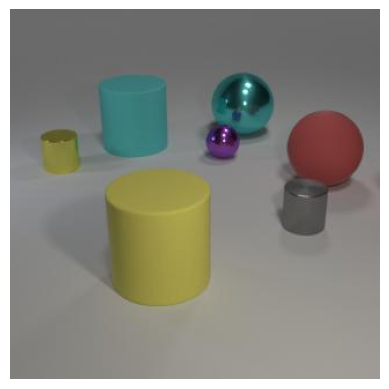

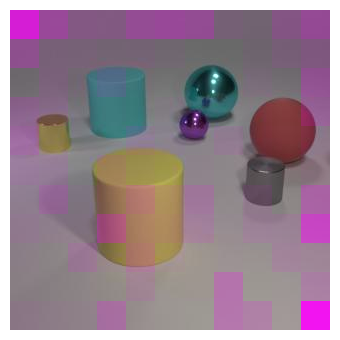

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2

image = Image.open(messages[0]["content"][0]["image"])

# Customize color map, transparent to magenta
colors = [(1, 0, 1, 0), (1, 0, 1, 1)]  # From transparent to magenta
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

plt.imshow(image)
plt.axis("off")
plt.show()

for i, visual_attn in enumerate(visual_attn_map):
    # Resize the attention map to the image size
    visual_attn = cv2.resize(
        visual_attn, (image.width, image.height), interpolation=cv2.INTER_NEAREST_EXACT
    )
    #
    plt.imshow(visual_attn, cmap='viridis')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.gca().set_frame_on(False)
    plt.gcf().set_size_inches(320/100, 320/100)  # Convert to inches (dpi=100 by default)
    plt.savefig(f"attn_layer_{i}.png", dpi=320)
    plt.imshow(image)
    plt.imshow(visual_attn, cmap=cmap, vmin=0, vmax=0.01)
    plt.axis("off")
    # plt.title(f"Layer {i}")
    # disable the white boarder
    plt.tight_layout(pad=0)
    plt.gca().set_frame_on(False)
    plt.gcf().set_size_inches(320/100, 320/100)  # Convert to inches (dpi=100 by default)
    plt.savefig(f"visual_attn_layer_{i}.png", dpi=320)
    # plt.show()


In [50]:
for i, attn_map in enumerate(visual_attn_map):
    s = attn_map.flatten()
    # get entropy
    s = -s * np.log(s)
    s = s.sum()
    print(f'Layer {i} entropy: {s}')


Layer 0 entropy: 0.4852445125579834
Layer 1 entropy: 0.47567909955978394
Layer 2 entropy: 0.44413939118385315
Layer 3 entropy: 0.6688017249107361
Layer 4 entropy: 0.877448558807373
Layer 5 entropy: 0.6405865550041199
Layer 6 entropy: 0.6742904782295227
Layer 7 entropy: 0.544845700263977
Layer 8 entropy: 0.31301820278167725
Layer 9 entropy: 0.4200748801231384
Layer 10 entropy: 1.1344228982925415
Layer 11 entropy: 0.6579217314720154
Layer 12 entropy: 0.8793476223945618
Layer 13 entropy: 0.49916526675224304
Layer 14 entropy: 0.9751321077346802
Layer 15 entropy: 0.6851258277893066
Layer 16 entropy: 0.5635092258453369
Layer 17 entropy: 0.5657840967178345
Layer 18 entropy: 0.21516253054141998
Layer 19 entropy: 0.48659747838974
Layer 20 entropy: 0.8668044209480286
Layer 21 entropy: 0.8134980201721191
Layer 22 entropy: 0.5725045204162598
Layer 23 entropy: 0.5481521487236023
Layer 24 entropy: 0.37567439675331116
Layer 25 entropy: 0.6676397919654846
Layer 26 entropy: 0.6659753918647766
Layer 27 

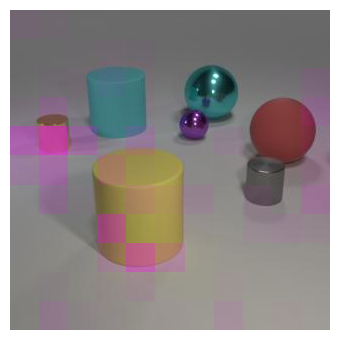

In [71]:
# s = np.exp(np.log(visual_attn_map[14] / visual_attn_map[14].sum()) - np.log(visual_attn_map[6]))
s = np.maximum(0, visual_attn_map[14] - visual_attn_map[6])  # ReLU operation
# s = s / s.sum()

plt.axis("off")
plt.imshow(image)
# plt.imshow(s, cmap='viridis')
# plt.savefig(f"contrastive_attn.png", dpi=320)
# plt.savefig(f"visual_attn_layer_{i}.png", dpi=320)
s = cv2.resize(s, (image.width, image.height), interpolation=cv2.INTER_NEAREST_EXACT)
plt.imshow(s, cmap=cmap, alpha=0.5) 

plt.tight_layout(pad=0)
plt.gca().set_frame_on(False)
plt.gcf().set_size_inches(320/100, 320/100)  # Convert to inches (dpi=100 by default)

plt.savefig(f"contrastive_attn_overlay.png", dpi=320)
plt.show()


In [ ]:
aw = get_mean_attn_score(output_ids)

# neg_aw = get_mean_attn_score(negative_output_ids)
aw.shape


In [ ]:
vw = get_visual_token_mean_attn_score(
    aw,
    inputs,
    model_2b.config.vision_start_token_id,
    model_2b.config.vision_end_token_id,
)

# neg_vw = get_visual_token_mean_attn_score(
#     neg_aw,
#     neg_inputs,
#     model_2b.config.vision_start_token_id,
#     model_2b.config.vision_end_token_id,
# )
_ = [print(v.shape) for v in vw]


In [ ]:
(inputs.image_grid_thw[0][1:] // 2).prod()


In [13]:
vm_linear = [
  get_visual_token_weight(v, 0.6, 1.0, "linear", 0.0) for v in vw
]
model_7b.embed_weight = torch.concat(vm_linear, dim=0).to(model_7b.device)


In [14]:
model_7b.forward = patch_forward.__get__(model_7b, Qwen2VLForConditionalGeneration)


In [ ]:
generated_ids = model_7b.generate(**inputs.to(model_7b.device), max_new_tokens=128)
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, generated_ids)
]
out = processor.tokenizer.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
response = out[0]


In [ ]:
print(response)


## OLD CODE

In [19]:
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, generated_ids)
]
out = processor.tokenizer.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
response = out[0]


In [ ]:
print(response)


In [ ]:
with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=512,
        return_dict_in_generate=True,
        output_hidden_states=True,
        output_attentions=True,
        use_cache=True,
    )

print(output_ids)


In [ ]:
with torch.no_grad():
    output_ids = model.generate(
        **inputs,
        max_new_tokens=512,
    )
print(output_ids)


In [ ]:
# Decode and echo output
generated_ids = [
    output_ids[len(input_ids):]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids.sequences)
]
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)
_ = [print(output) for output in output_text]


In [ ]:
from typing import Tuple, List
from torch import Tensor
import copy

vision_start_token_idx = inputs['input_ids'][0].tolist().index(model.config.vision_start_token_id)
vision_end_token_idx = inputs['input_ids'][0].tolist().index(model.config.vision_end_token_id)

output_attn: Tuple[Tuple[Tensor, ...], ...] = copy.deepcopy(output_ids.attentions)
# get the length of the prefilling and full attention
pref_len: int = output_attn[0][0].shape[3]
full_len: int = output_attn[-1][0].shape[3]
prefill_attn: Tuple[Tensor, ...] = output_attn[0]

# batchsize should be 1
assert prefill_attn[0].shape[0] == 1
full_attn = []
for l, layer in enumerate(prefill_attn):
    layer = layer.cpu().squeeze(0).float()
    layer = F.pad(layer, (0, full_len - pref_len, 0, full_len - pref_len))
    for i in range(full_len - pref_len):
        # print(i, )
        # cur_attn = output_attn[i][l].cpu().squeeze(0).float()
        cur_attn = output_attn[i + 1][l].cpu().squeeze(0)[:, 0, :].float()
        # print(cur_attn.shape)
        layer[:, pref_len + i, :pref_len + i + 1] = cur_attn
    full_attn.append(layer)
mean_attn = torch.stack(full_attn).mean(dim=(0, 1))

image_output_attn = torch.mean(mean_attn[pref_len:, vision_start_token_idx + 1:vision_end_token_idx], dim=0)

def calculate_dynamic_threshold(attn, percentile=98):
    hist = torch.histc(attn, bins=100)
    cdf = torch.cumsum(hist, dim=0)/torch.sum(hist)
    threshold = torch.argmax((cdf > percentile/100).float()).item()/100
    return threshold

threshold = calculate_dynamic_threshold(image_output_attn)
print(threshold)


In [ ]:
def reweighted_vision_tokens(attn_map, keep_percentage=threshold):
    # Get the attention values sorted in descending order
    sorted_attention, sorted_indices = torch.sort(attn_map, descending=True)
    
    # Determine the number of tokens to keep
    num_tokens_to_keep = int(len(sorted_attention) * keep_percentage)
    
    # Create a weight mask where the top tokens have higher weight
    weight_vision_token = torch.zeros_like(attn_map, dtype=torch.float)
    
    # Assign weights for tokens (top tokens get higher weights, others get smaller weights)
    weight_vision_token[sorted_indices[:num_tokens_to_keep]] = 1.0
    weight_vision_token[sorted_indices[num_tokens_to_keep:]] = torch.linspace(0.6, 1.0, len(sorted_attention) - num_tokens_to_keep)

    return weight_vision_token
    
weight_vision_token = reweighted_vision_tokens(image_output_attn).to('cuda')


In [ ]:
weight_vision_token


In [ ]:
# weight_vision_token.size()
input_ids = inputs["input_ids"]
n_image_tokens = (input_ids == model.config.image_token_id).sum().item()
print(n_image_tokens)


In [ ]:
print(inputs["input_ids"])


In [ ]:
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]
pixel_values = inputs["pixel_values"]
image_grid_thw = inputs["image_grid_thw"]

inputs_embeds = model.model.embed_tokens(input_ids)
if pixel_values is not None:
    pixel_values = pixel_values.type(model.visual.get_dtype())
    image_embeds = model.visual(pixel_values, grid_thw=image_grid_thw)
    n_image_tokens = (input_ids == model.config.image_token_id).sum().item()
    n_image_features = image_embeds.shape[0]
    if n_image_tokens != n_image_features:
        raise ValueError(
            f"Image features and image tokens do not match: tokens: {n_image_tokens}, features {n_image_features}"
        )
    image_mask = (
        (input_ids == model.config.image_token_id)
        .unsqueeze(-1)
        .expand_as(inputs_embeds)
        .to(inputs_embeds.device)
    )
    image_embeds = image_embeds.to(inputs_embeds.device, inputs_embeds.dtype)
    print(image_embeds)
    image_embeds *= weight_vision_token[:, None]
    print(image_embeds)
    inputs_embeds = inputs_embeds.masked_scatter(image_mask, image_embeds)

if attention_mask is not None:
    attention_mask = attention_mask.to(inputs_embeds.device)

print(image_embeds.shape)



In [ ]:
generated_ids = model.generate(inputs_embeds=inputs_embeds, max_new_tokens=2048)


In [ ]:
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)
_ = [print(output) for output in output_text]
